# IMAGEN - ERROR ANALYSIS
The preliminary results in our IMAGEN paper advocates for a more in-depth understanding of what contributes to the significant performance of the ML models for the three time-points: <br>
<li>Baseline (<b>BL</b>): Age <tr> <b>14</b></li>
<li>Follow 1 year (<b>FU1</b>): Age <b>16</b></li>
<li>Follow 2 year (<b>FU2</b>): Age <b>19</b></li>
<li>Follow 3 year (<b>FU3</b>): Age <b>22</b></li>

Such in-depth understanding can be achieved by performing follow-up analysis such as: <br>

## Overview

## Error Analysis

In [1]:
################################################################################
""" IMAGEN - ERROR ANALYSIS """
# Author : JiHoon Kim, <jihoon.kim@fu-berlin.de>, 9th September 2021
#
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np
from glob import glob
from os.path import join 
import os 
from scikits.bootstrap import ci
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from plotResults import *

In [17]:
from imagen_instrumentloader import *
from imagen_plot_statistics import *

In [18]:
def violin_plot(DATA, ROI):
    for col in ROI:
        sns.set(style="whitegrid", font_scale=1)
        fig, axes = plt.subplots(nrows=1, ncols=len(DATA), figsize = ((len(DATA)+1)**2, len(DATA)+1))
        fig.suptitle(f'{col}', fontsize=15)
        for i, (Key, DF) in enumerate(DATA):
            axes[i].set_title(f'{Key} = {str(len(DF[col].dropna()))}')
            sns.violinplot(x="Class", y=col, data = DF, order=['HC', 'AAM'],
                           inner="quartile", ax = axes[i], palette="Set2")
            add_stat_annotation(ax = axes[i], data=DF, x="Class", y=col,
                                box_pairs = [("HC","AAM")], order=["HC","AAM"],
                                test='t-test_ind', text_format='star', loc='inside')

### 1. Visualization

#### 1.1 probabilitiy distributions

In [2]:
df = pd.read_csv(sorted(glob("results/newlbls-fu3-espad-fu3-19a-binge-*/*/run.csv"))[-1])

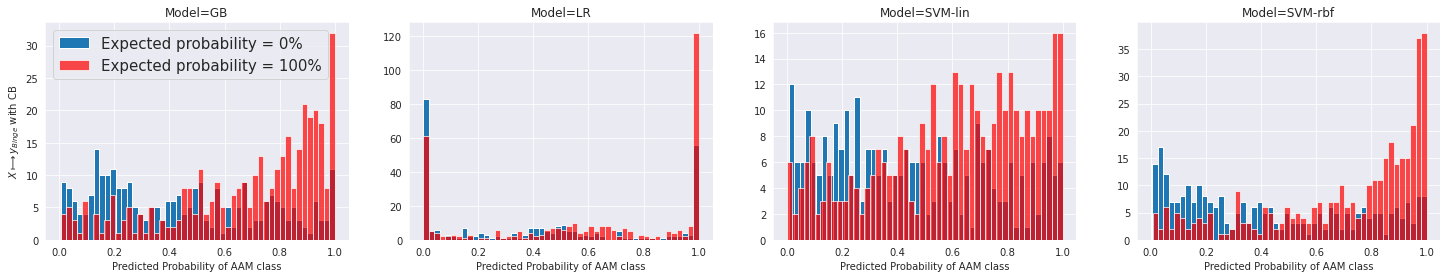

In [3]:
grp_order = ["io", "technique", "model"]
groups = df.groupby(grp_order)   
n_models = len(df["model"].unique())
n_rows = round(len(groups)/n_models)
fig, axes = plt.subplots(n_rows, n_models, 
                         sharex=True, sharey=False,
                         figsize=(25, n_models*n_rows))
axes = np.ravel(axes)
        
for i, (g, dfi) in enumerate(groups):
    ids_all = np.array([id_lists for ids in dfi["test_ids"] for id_lists in eval(ids)])
    assert ids_all.shape[0] == np.unique(ids_all).shape[0]
    probs_all = np.array([prob_lists for probs in dfi["test_probs"] for prob_lists in eval(probs)])
    y_all = np.array([y_lists for y in dfi["test_lbls"] for y_lists in eval(y)])
    assert probs_all.shape[0] == y_all.shape[0]

    prediction=probs_all[:,1]
    ax = axes[i]
    ax.hist(prediction[y_all==0], bins=50, label='Expected probability = 0%')
    ax.hist(prediction[y_all==1], bins=50, label='Expected probability = 100%', alpha=0.7, color='r')
    ax.set_xlabel('Predicted Probability of AAM class')
    if i%n_models == 0:
        ax.set_ylabel("{} with {}".format(remap_io(dfi.iloc[0]), g[1].upper()))
    if i == 0:
        ax.legend(fontsize=15)
    ax.set_title("Model={}".format(g[-1]))
    
plt.show()

### 2. Performance across sites

#### 2.1 main experiment

In [3]:
df = pd.read_csv(sorted(glob("results/newlbls-fu3-espad-fu3-19a-binge-*/*/run.csv"))[-1])

In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from itertools import chain, repeat
from imagen_instrumentloader import *

test_id = sum([df['test_ids'][i].strip('][').split(', ') for i in range(28)], [])
test_probs = np.array([prob_lists for probs in df["test_probs"] for prob_lists in eval(probs)])[:,1]
test_lbls = sum([df['test_lbls'][i].strip('][').split(', ') for i in range(28)], [])
model = [g for (g, dfi) in df.groupby(["i", "o", "technique", "model"])]
test_model = list(chain.from_iterable((repeat(number, 650) for number in model)))

df2 = pd.DataFrame({
    "ID" : test_id,
    "Model" : test_model,
    "Probability" : test_probs, 
    "Labels" : test_lbls,})
DF = df2.astype({"ID":'int', "Probability":'float', "Labels":'float'})

TP = (DF.Labels == 1.0) & (DF.Probability >= 0.5)
TN = (DF.Labels == 0.0) & (DF.Probability <= 0.5)
FP = (DF.Labels == 0.0) & (DF.Probability >= 0.5)
FN = (DF.Labels == 1.0) & (DF.Probability <= 0.5)

DF['TP'] = DF[TP]['Probability']
DF['TN'] = DF[TN]['Probability']
DF['FP'] = DF[FP]['Probability']
DF['FN'] = DF[FN]['Probability']
DF['T'] = DF[TP | TN]['Probability']
DF['F'] = DF[FP | FN]['Probability']

CTQ = IMAGEN_instrument()
binge_CTQ = CTQ.read_instrument(
    'newlbls-fu3-espad-fu3-19a-binge-n650_CTQ.csv'
)
col_binge_CTQ = binge_CTQ.columns[:-6]
DF = pd.merge(DF, binge_CTQ[['ID','Site']], on='ID', how = 'outer')

DF.to_csv('newlbls-fu3-espad-fu3-19a-binge-n650_run.csv', index=False)

In [46]:
# # DF = pd.read_csv('newlbls-fu3-espad-fu3-19a-binge-n650_run.csv')
# models = DF.groupby(['Site','Model']) 

# for i, (g, dfi) in enumerate(models):
#     print(g[0])
#     y_true = dfi['Labels'].to_list()
#     y_pred = np.round(dfi['Probability'].to_list())
#     # classification report
#     print(f"Classification report {dfi['Model'].iloc[0]} \n"
#           f"{classification_report(y_true, y_pred, target_names=['HC', 'AAM'])}")
#     # Confusion Matrix
#     print(f'confusion matrix \n {confusion_matrix(y_true, y_pred)} \n'
#     # Accuracy
#           f'accruacy score \n {accuracy_score(y_true, y_pred)} \n'
#     # Recall
#           f'recall score \n {recall_score(y_true, y_pred, average=None)} \n'
#     # Precision
#           f'precision score \n {precision_score(y_true, y_pred, average=None)} \n'
#     # f1 Score
#           f'f1_score \n {f1_score(y_true, y_pred, average=None)} \n')

In [19]:
binge_CTQ_Sex = binge_CTQ.groupby(['Sex'])
binge_CTQ_M = binge_CTQ_Sex.get_group('Male')
binge_CTQ_F = binge_CTQ_Sex.get_group('Female')

In [20]:
DATA = [('All',binge_CTQ), ('Male',binge_CTQ_M), ('Female',binge_CTQ_F)]
ROI = [col_binge_CTQ[-1]]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=1.223e-03 stat=3.251e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=2.028e-03 stat=3.117e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=8.576e-01 stat=1.796e-01


Denial sum
Sex    Class            
Female AAM      7.973118
       HC       8.039474
Male   AAM      8.150442
       HC       9.198718

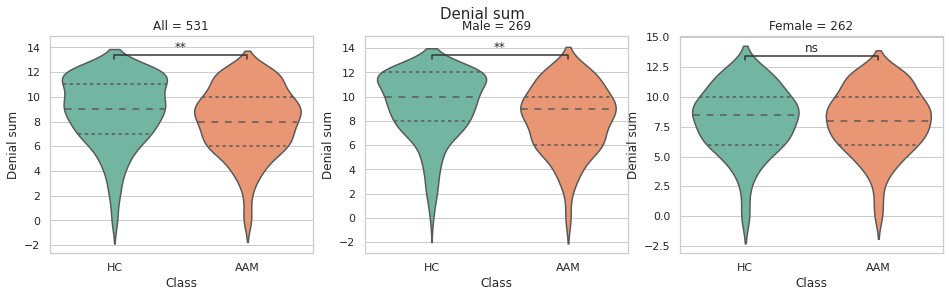

In [21]:
violin_plot(DATA, ROI)
binge_CTQ.groupby(['Sex','Class'])[ROI].mean()

In [8]:
# import joypy
# %matplotlib inline

In [7]:
################################################################################
from imagen_instrumentloader import *
from imagen_plot_statistics import *
# DATA_DIR = '/ritter/share/data/IMAGEN'

In [25]:
DF = pd.read_csv('newlbls-fu3-espad-fu3-19a-binge-n650_run.csv')

In [26]:
CTQ = IMAGEN_instrument()
binge_CTQ = CTQ.read_instrument(
    'newlbls-fu3-espad-fu3-19a-binge-n650_CTQ.csv'
)
col_binge_CTQ = binge_CTQ.columns[:-6]

In [27]:
Prob = DF.groupby('Site').count()

In [28]:
Prob['ACC'] = Prob['T']/Prob['Probability']*100

In [29]:
Prob

ID  Model  Probability  Labels   TP   TN  FP  FN    T    F  \
Site                                                                      
Berlin      328    328          328     328   18  239  49  22  257   71   
Dresden     372    372          372     372  268   15  50  41  283   91   
Dublin      260    260          260     260   63   79  50  69  142  119   
Hamburg     324    324          324     324  190   24  52  59  214  111   
London      356    356          356     356  128   65  91  74  193  165   
Mannheim    332    332          332     332  259    2  39  34  261   73   
Nottingham  300    300          300     300   48  139  66  48  187  114   
Paris       328    328          328     328   83  117  55  74  200  129   

                  ACC  
Site                   
Berlin      78.353659  
Dresden     76.075269  
Dublin      54.615385  
Hamburg     66.049383  
London      54.213483  
Mannheim    78.614458  
Nottingham  62.333333  
Paris       60.975610

In [30]:
binge_ML = DF.groupby('Model')
binge_ML_GB = binge_ML.get_group("('X', 'Binge', 'cb', 'GB')")
binge_ML_LR = binge_ML.get_group("('X', 'Binge', 'cb', 'LR')")
binge_ML_SVM_lin = binge_ML.get_group("('X', 'Binge', 'cb', 'SVM-lin')")
binge_ML_SVM_rbf = binge_ML.get_group("('X', 'Binge', 'cb', 'SVM-rbf')")

In [31]:
binge_ML_GB_T = binge_ML_GB[['ID','T']].dropna(axis=0)
binge_ML_GB_F = binge_ML_GB[['ID','F']].dropna(axis=0)
GB_T = binge_ML_GB_T['ID'].values.tolist()
GB_F = binge_ML_GB_F['ID'].values.tolist()

In [32]:
binge_ML_LR_T = binge_ML_LR[['ID','T']].dropna(axis=0)
binge_ML_LR_F = binge_ML_LR[['ID','F']].dropna(axis=0)
LR_T = binge_ML_LR_T['ID'].values.tolist()
LR_F = binge_ML_LR_F['ID'].values.tolist()

In [33]:
binge_ML_SVM_lin_T = binge_ML_SVM_lin[['ID','T']].dropna(axis=0)
binge_ML_SVM_lin_F = binge_ML_SVM_lin[['ID','F']].dropna(axis=0)
SVM_lin_T = binge_ML_SVM_lin_T['ID'].values.tolist()
SVM_lin_F = binge_ML_SVM_lin_F['ID'].values.tolist()

In [34]:
binge_ML_SVM_rbf_T = binge_ML_SVM_rbf[['ID','T']].dropna(axis=0)
binge_ML_SVM_rbf_F = binge_ML_SVM_rbf[['ID','F']].dropna(axis=0)
SVM_rbf_T = binge_ML_SVM_rbf_T['ID'].values.tolist()
SVM_rbf_F = binge_ML_SVM_rbf_F['ID'].values.tolist()

In [36]:
DATA = [('All',binge_CTQ), ('Male',binge_CTQ_M), ('Female',binge_CTQ_F),
        ('GB T',binge_CTQ.set_index('ID').loc[GB_T]), ('GB F',binge_CTQ.set_index('ID').loc[GB_F]),
        ('LR T',binge_CTQ.set_index('ID').loc[LR_T]), ('LR F',binge_CTQ.set_index('ID').loc[LR_F]),
        ('SVM lin T',binge_CTQ.set_index('ID').loc[SVM_lin_T]), ('SVM lin F',binge_CTQ.set_index('ID').loc[SVM_lin_F]),
        ('SVM rbf T',binge_CTQ.set_index('ID').loc[SVM_rbf_T]), ('SVM rbf F',binge_CTQ.set_index('ID').loc[SVM_rbf_F])]
ROI = [col_binge_CTQ[-1]]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=1.223e-03 stat=3.251e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=2.028e-03 stat=3.117e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=8.576e-01 stat=1.796e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bo

Denial sum
Sex    Class            
Female AAM      7.973118
       HC       8.039474
Male   AAM      8.150442
       HC       9.198718

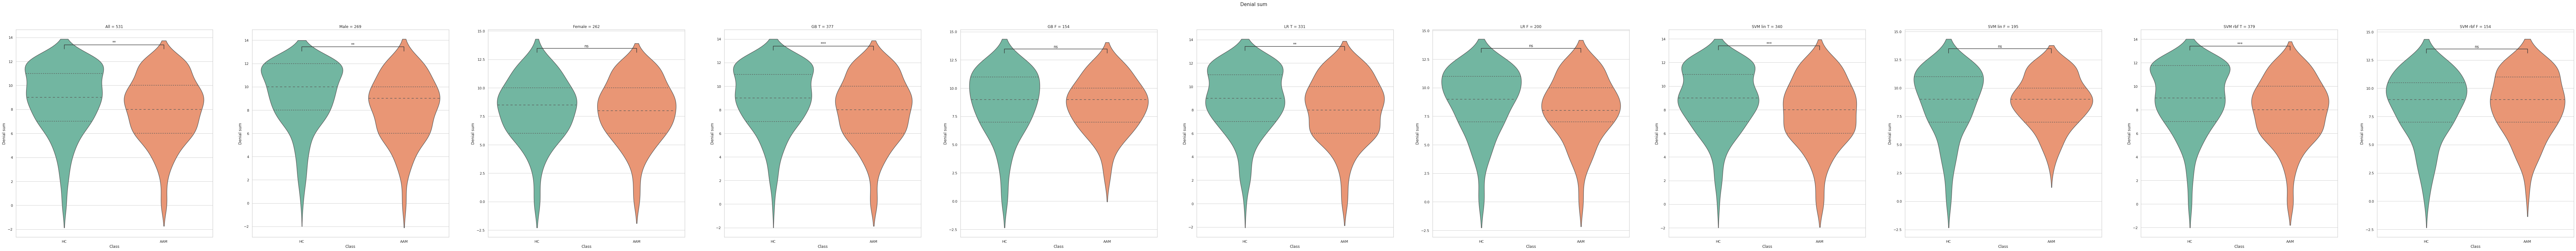

In [37]:
violin_plot(DATA, ROI)
binge_CTQ.groupby(['Sex','Class'])[ROI].mean()

In [42]:
binge_CTQ_Sex = binge_CTQ.groupby(['Sex'])
binge_CTQ_M = binge_CTQ_Sex.get_group('Male')
binge_CTQ_F = binge_CTQ_Sex.get_group('Female')
binge_CTQ_GB_T = binge_CTQ.set_index('ID').loc[GB_T]
binge_CTQ_GB_T_M = binge_CTQ.set_index('ID').loc[GB_T].groupby(['Sex']).get_group('Male')
binge_CTQ_GB_T_F = binge_CTQ.set_index('ID').loc[GB_T].groupby(['Sex']).get_group('Female')
binge_CTQ_GB_F = binge_CTQ.set_index('ID').loc[GB_F]
binge_CTQ_GB_F_M = binge_CTQ.set_index('ID').loc[GB_F].groupby(['Sex']).get_group('Male')
binge_CTQ_GB_F_F = binge_CTQ.set_index('ID').loc[GB_F].groupby(['Sex']).get_group('Female')

# ('LR T',binge_CTQ.set_index('ID').loc[LR_T]), ('LR F',binge_CTQ.set_index('ID').loc[LR_F]),
# ('SVM lin T',binge_CTQ.set_index('ID').loc[SVM_lin_T]), ('SVM lin F',binge_CTQ.set_index('ID').loc[SVM_lin_F]),
# ('SVM rbf T',binge_CTQ.set_index('ID').loc[SVM_rbf_T]), ('SVM rbf F',binge_CTQ.set_index('ID').loc[SVM_rbf_F])

In [44]:
DATA = [('All',binge_CTQ),('Male',binge_CTQ_M),('Female',binge_CTQ_F),
        ('GB T',binge_CTQ_GB_T),('GB T M',binge_CTQ_GB_T_M),('GB T F',binge_CTQ_GB_T_F),
        ('GB F',binge_CTQ_GB_F),('GB F M',binge_CTQ_GB_F_M),('GB F F',binge_CTQ_GB_F_F)]
ROI = [col_binge_CTQ[-1]]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=1.223e-03 stat=3.251e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=2.028e-03 stat=3.117e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=8.576e-01 stat=1.796e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bo

Denial sum
Sex    Class            
Female AAM      7.973118
       HC       8.039474
Male   AAM      8.150442
       HC       9.198718

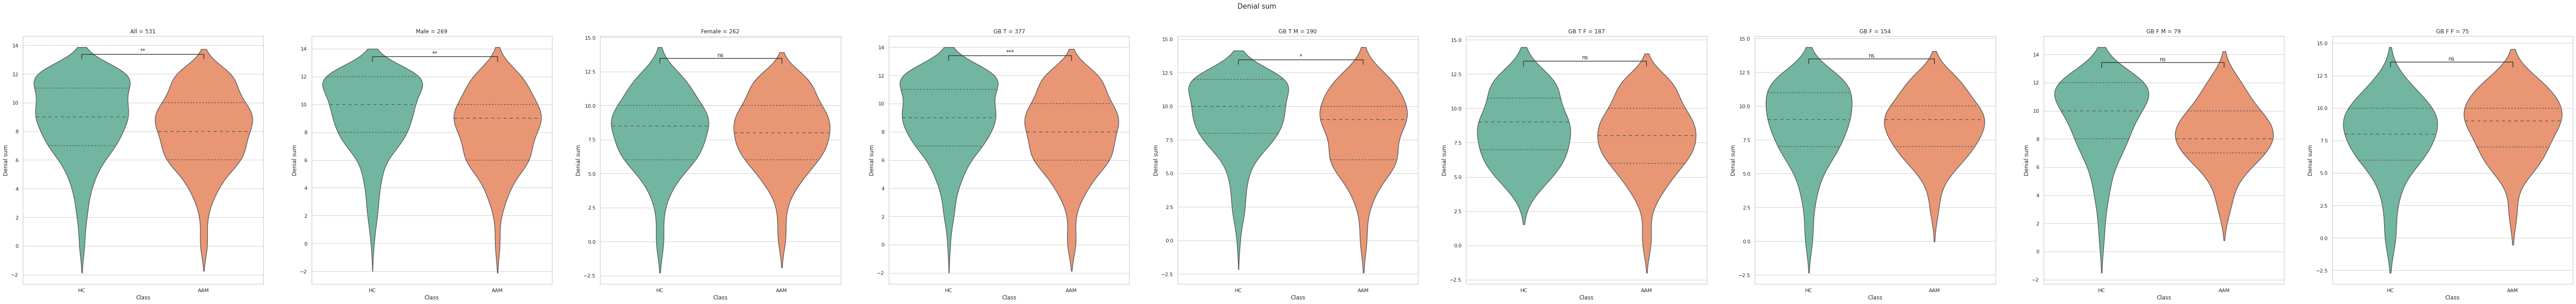

In [45]:
violin_plot(DATA, ROI)
binge_CTQ.groupby(['Sex','Class'])[ROI].mean()

### CTQ

In [31]:
DATA = [('All',binge_CTQ),
        ('True GB', binge_CTQ.set_index('ID').loc[GB_T, :]),
        ('True LR', binge_CTQ.set_index('ID').loc[LR_T, :]),
        ('True SVM lin', binge_CTQ.set_index('ID').loc[SVM_lin_T, :]),
        ('True SVM rbf', binge_CTQ.set_index('ID').loc[SVM_rbf_T, :])]
ROI = col_binge_CTQ

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=1.750e-01 stat=-1.358e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=2.622e-01 stat=-1.123e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=1.940e-01 stat=-1.302e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with

Emotional abuse sum  Physical abuse sum  Sexsual abuse sum  \
Sex    Class                                                               
Female AAM               2.177419            0.500000           0.360215   
       HC                1.986842            0.500000           0.052632   
Male   AAM               2.407080            0.460177           0.654867   
       HC                1.916667            0.256410           0.256410   

              Emotional neglect sum  Physical neglect sum  Denial sum  
Sex    Class                                                           
Female AAM                16.731183              7.795699    7.973118  
       HC                 16.592105              7.684211    8.039474  
Male   AAM                17.265487              8.115044    8.150442  
       HC                 17.711538              7.942308    9.198718

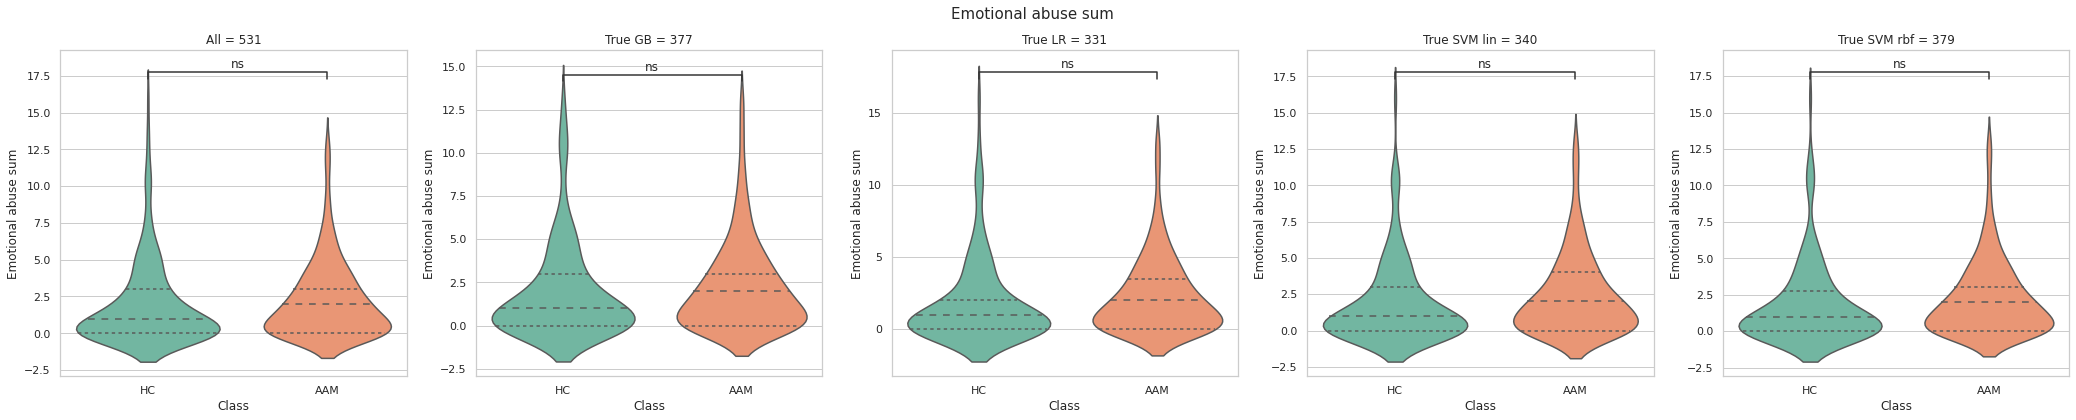

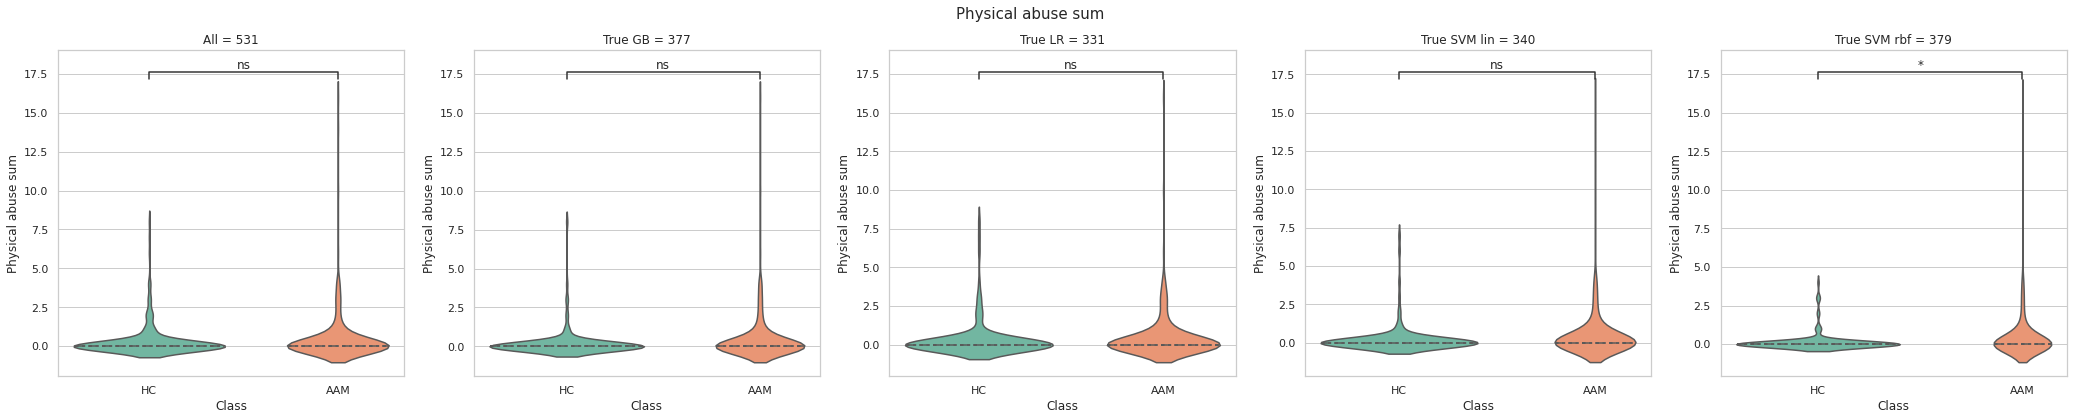

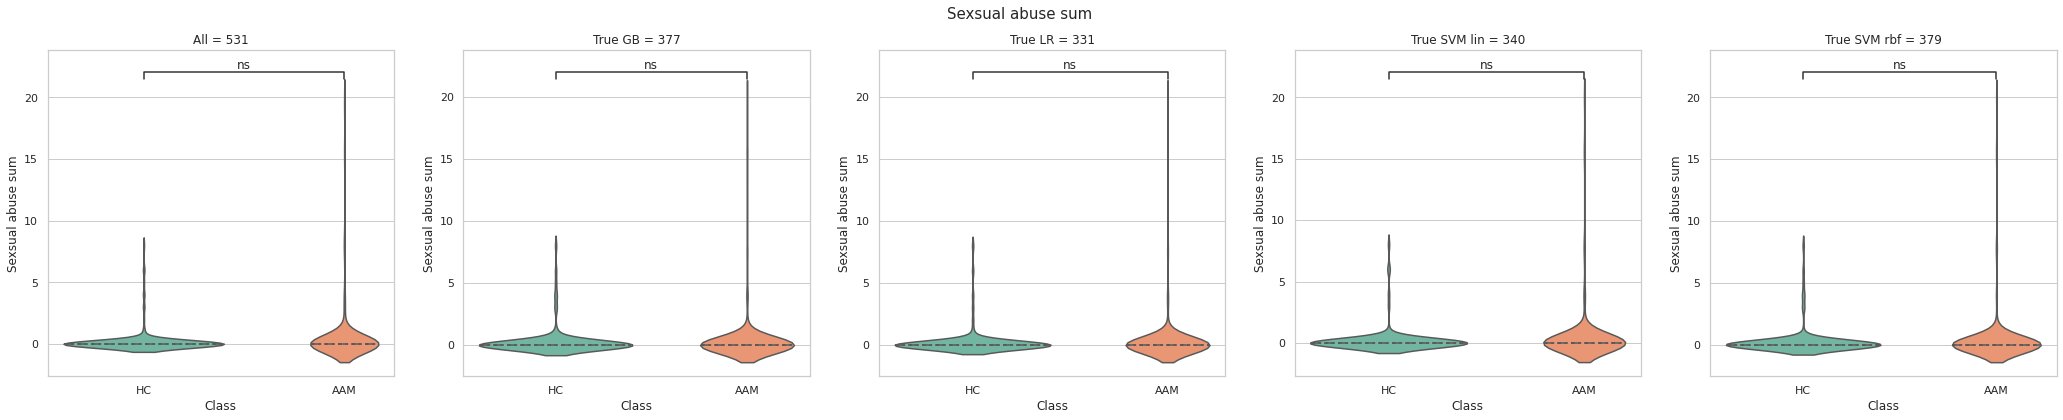

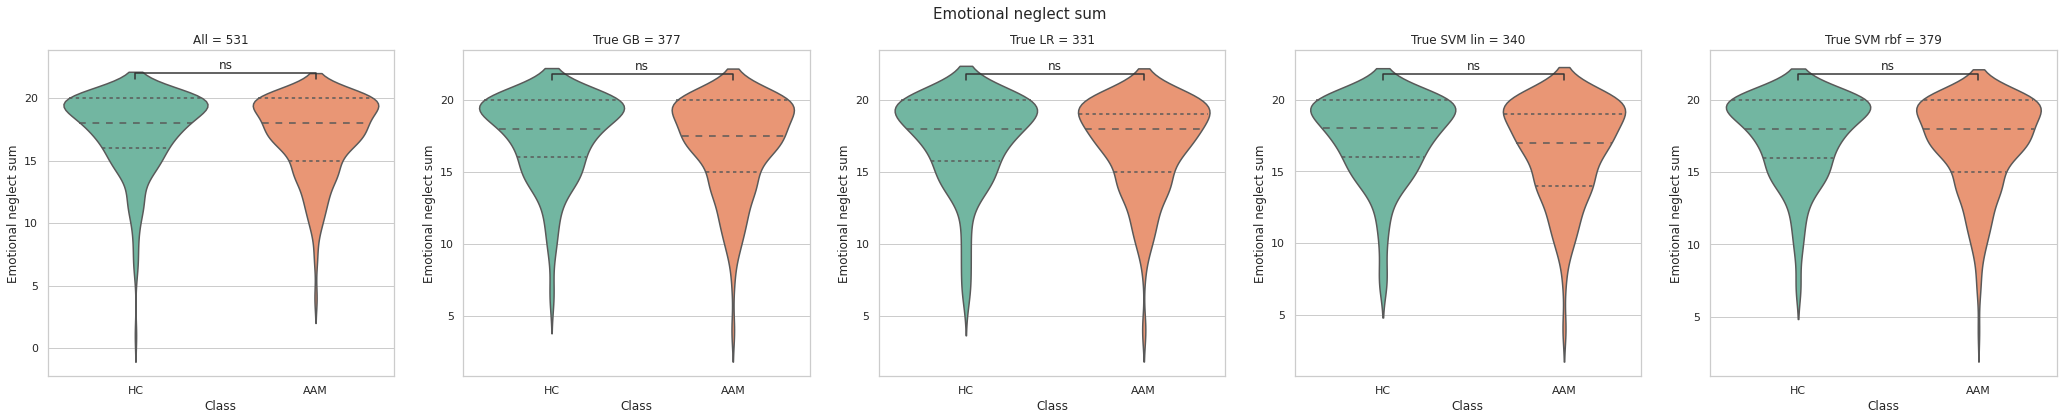

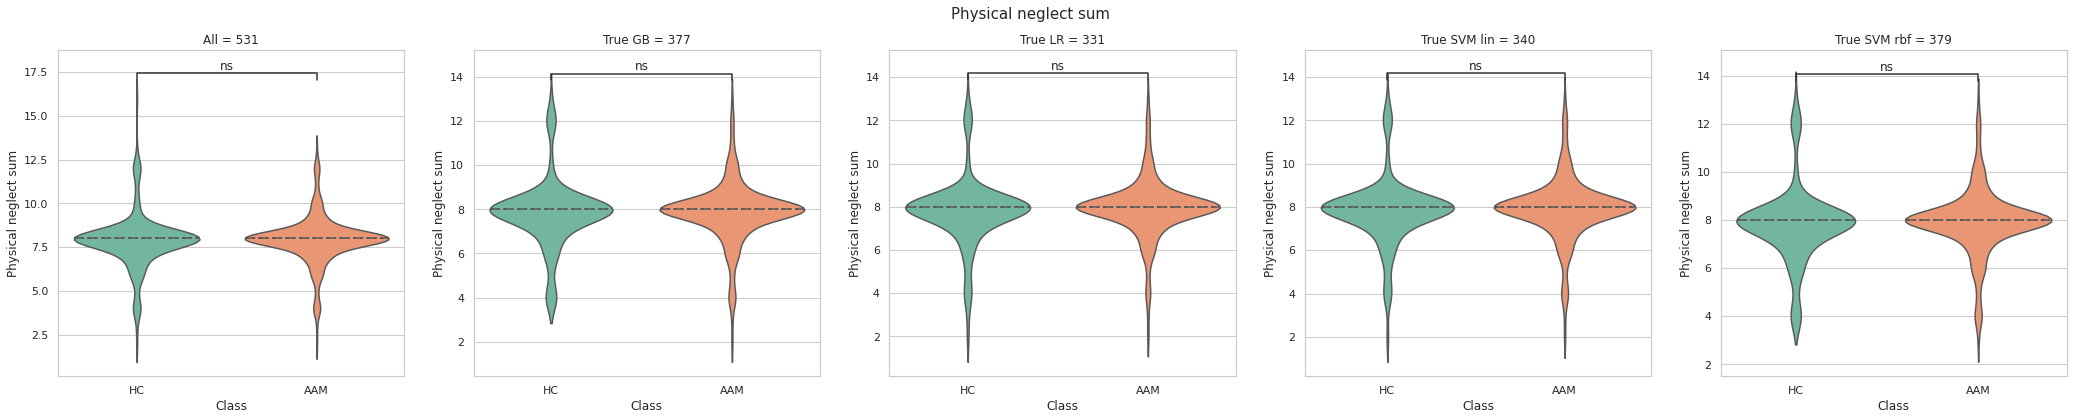

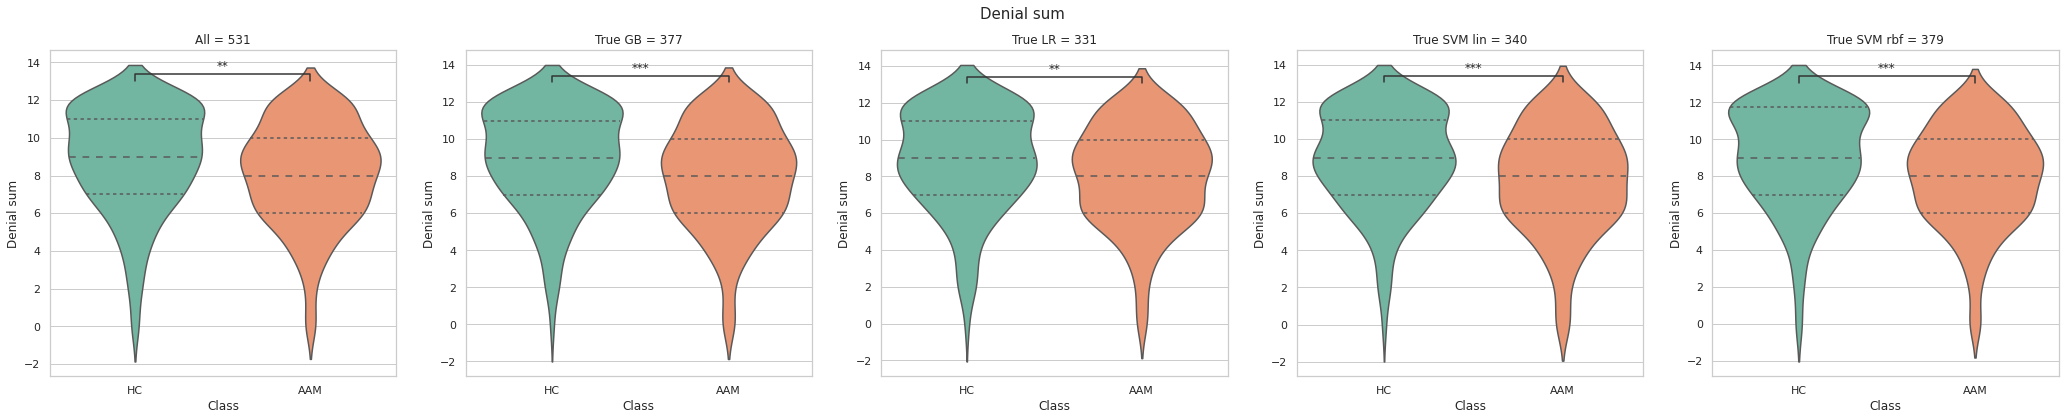

In [32]:
violin_plot(DATA, ROI)
binge_CTQ.groupby(['Sex','Class'])[ROI].mean()

In [33]:
DATA = [('All',binge_CTQ),
        ('False GB', binge_CTQ.set_index('ID').loc[GB_F, :]),
        ('False LR', binge_CTQ.set_index('ID').loc[LR_F, :]),
        ('False SVM lin', binge_CTQ.set_index('ID').loc[SVM_lin_F, :]),
        ('False SVM rbf', binge_CTQ.set_index('ID').loc[SVM_rbf_F, :])]
ROI = col_binge_CTQ

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=1.750e-01 stat=-1.358e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=4.628e-01 stat=-7.361e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=6.162e-01 stat=-5.021e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with

Emotional abuse sum  Physical abuse sum  Sexsual abuse sum  \
Sex    Class                                                               
Female AAM               2.177419            0.500000           0.360215   
       HC                1.986842            0.500000           0.052632   
Male   AAM               2.407080            0.460177           0.654867   
       HC                1.916667            0.256410           0.256410   

              Emotional neglect sum  Physical neglect sum  Denial sum  
Sex    Class                                                           
Female AAM                16.731183              7.795699    7.973118  
       HC                 16.592105              7.684211    8.039474  
Male   AAM                17.265487              8.115044    8.150442  
       HC                 17.711538              7.942308    9.198718

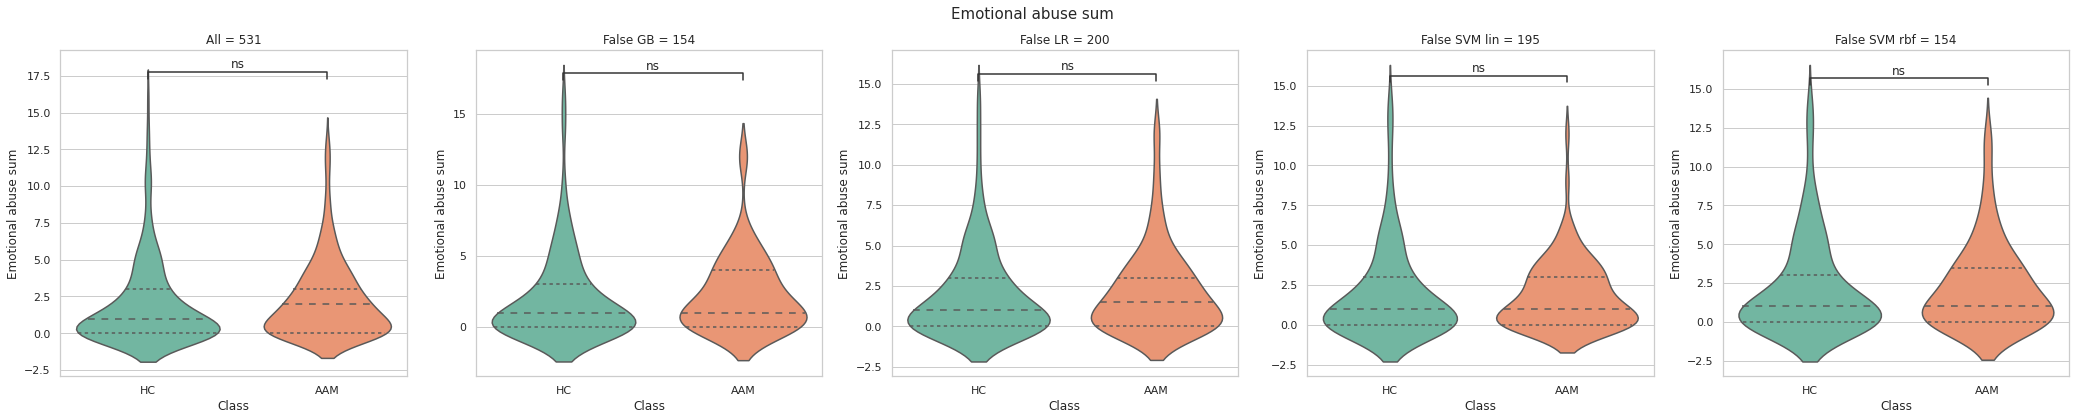

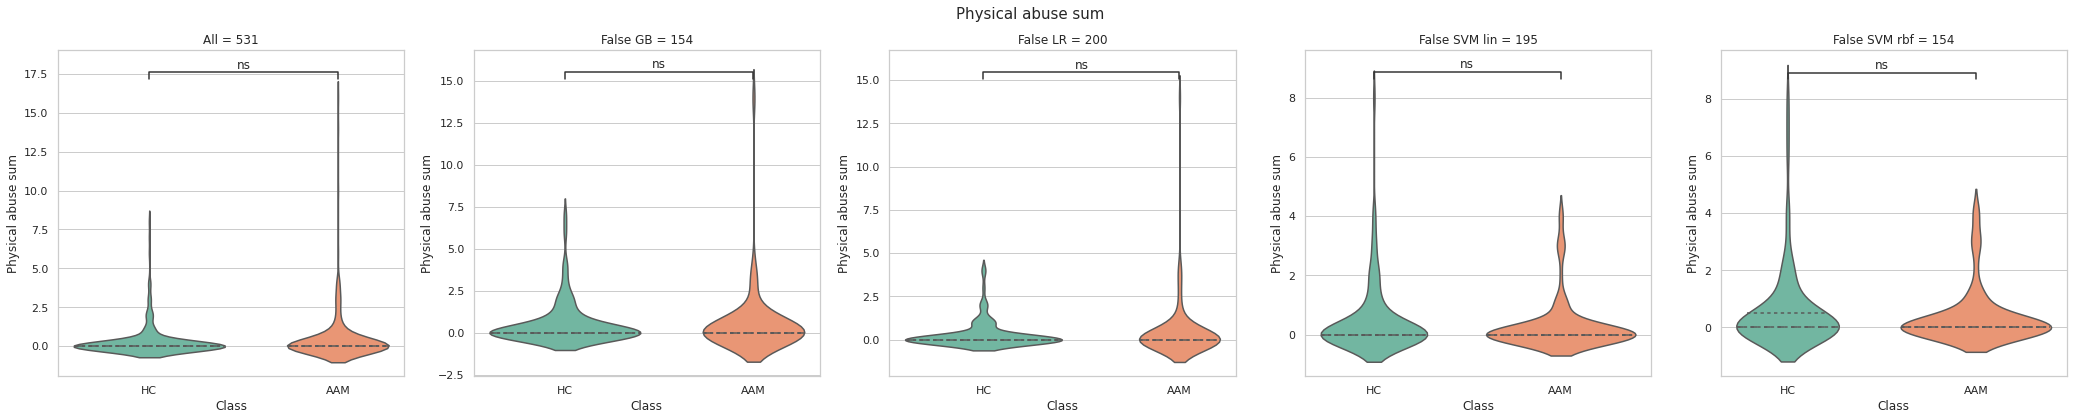

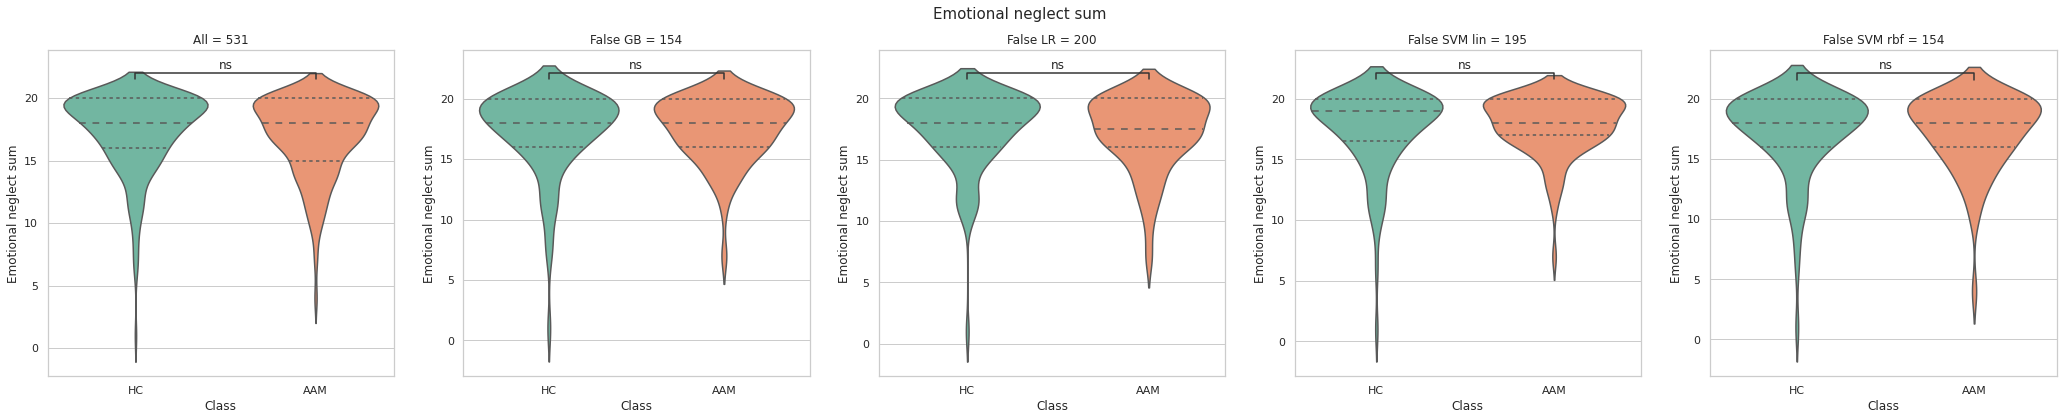

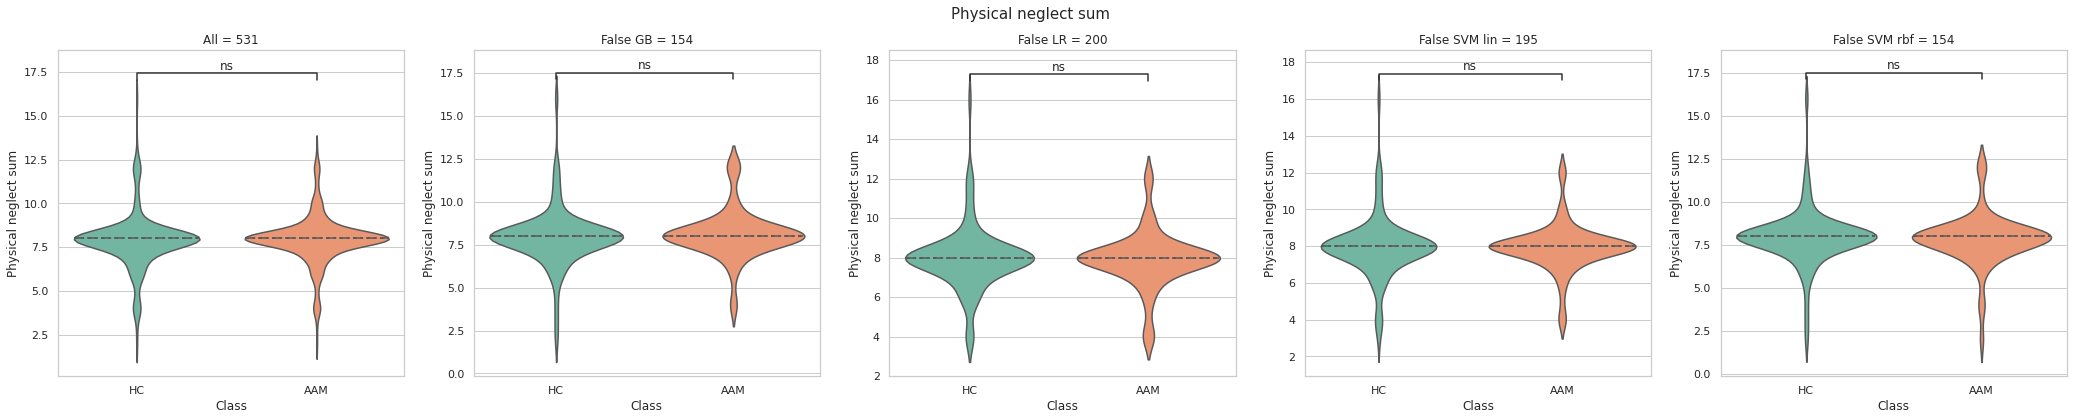

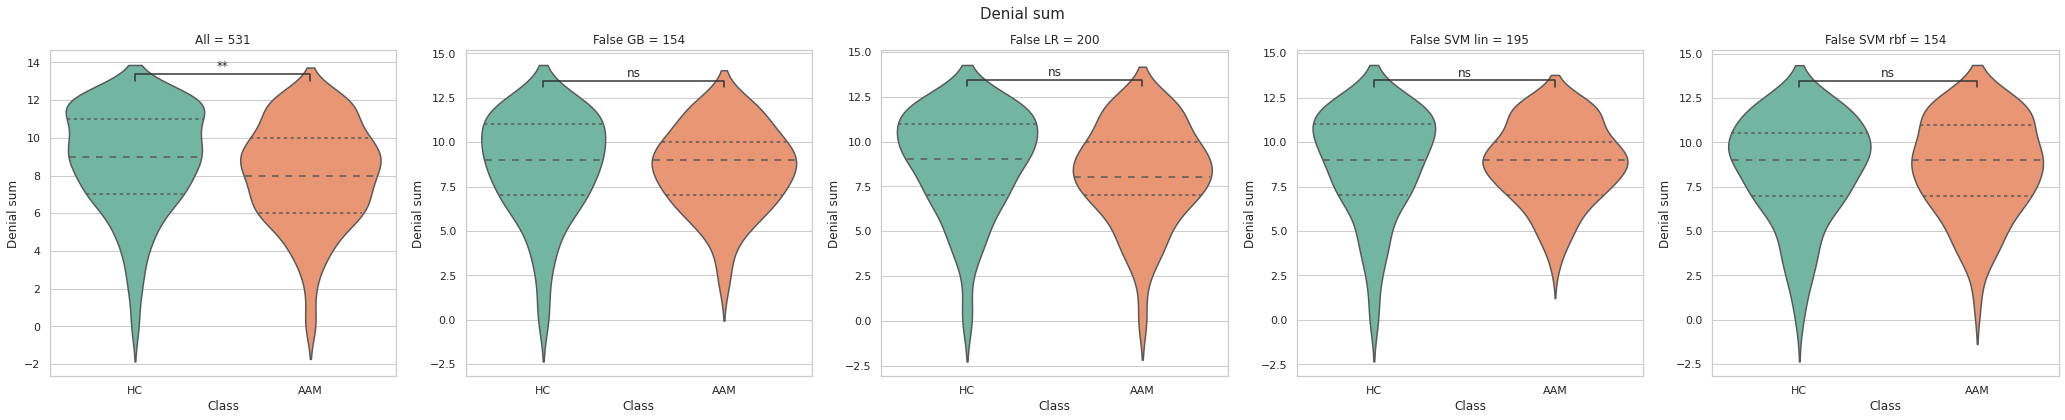

In [34]:
violin_plot(DATA, ROI)
binge_CTQ.groupby(['Sex','Class'])[ROI].mean()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=1.750e-01 stat=-1.358e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=2.246e-01 stat=-1.216e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=8.093e-02 stat=-1.749e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with

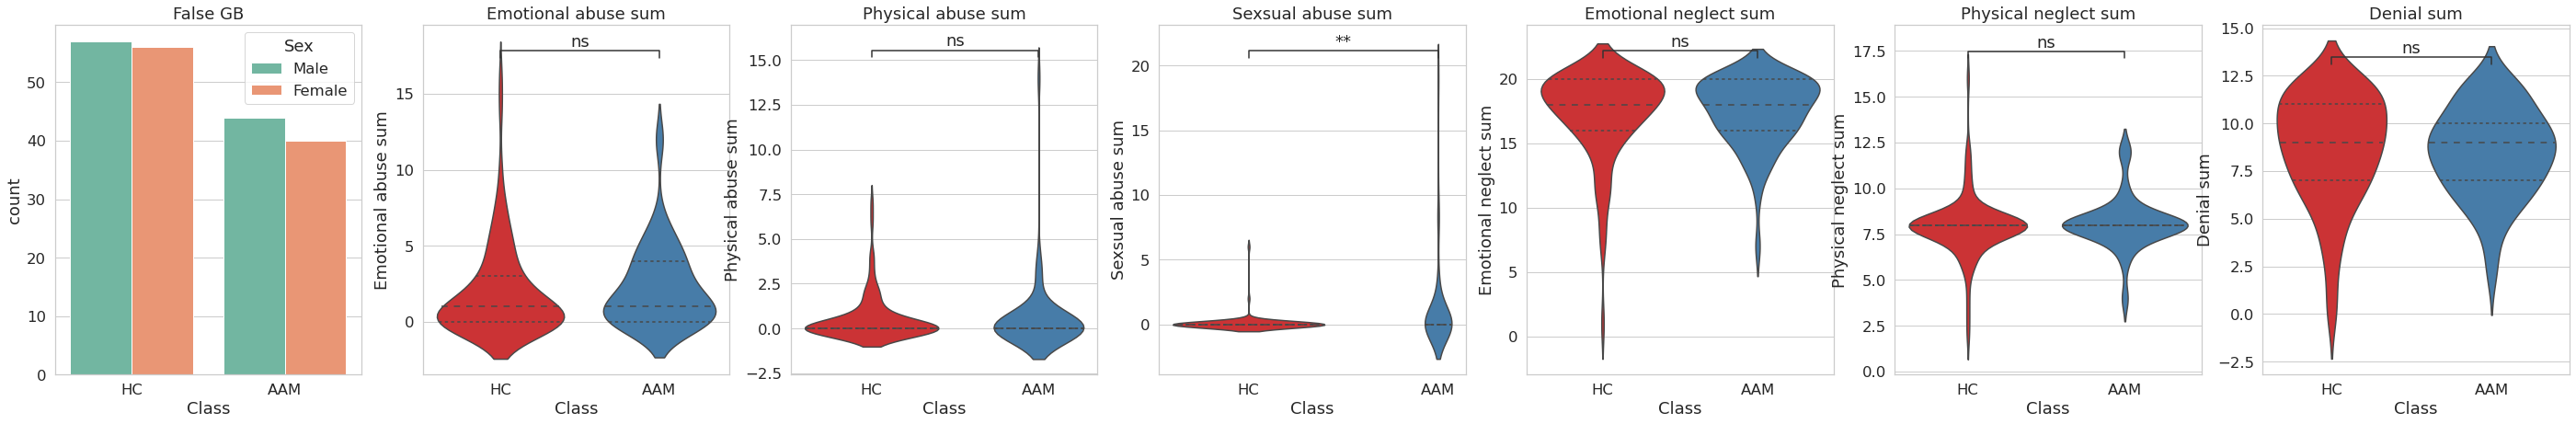

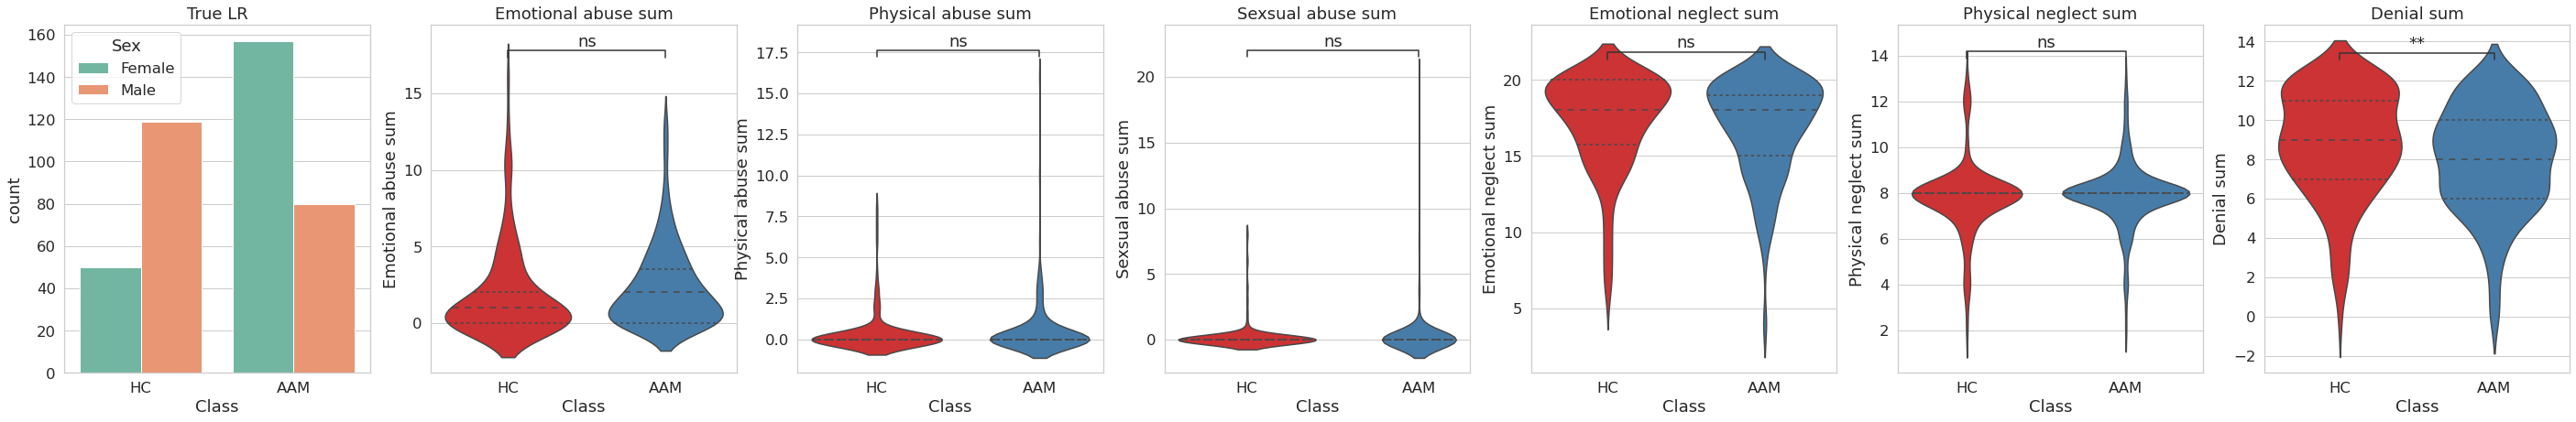

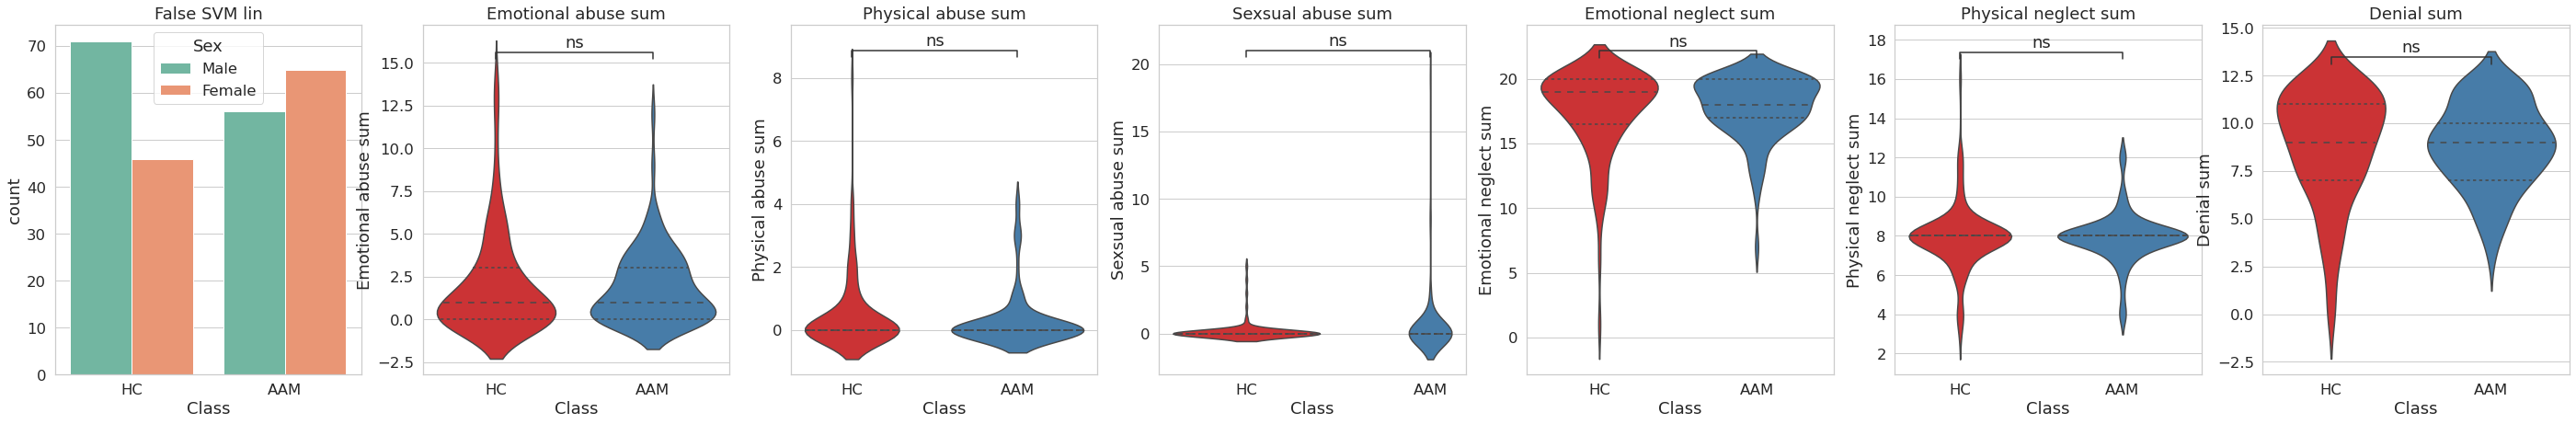

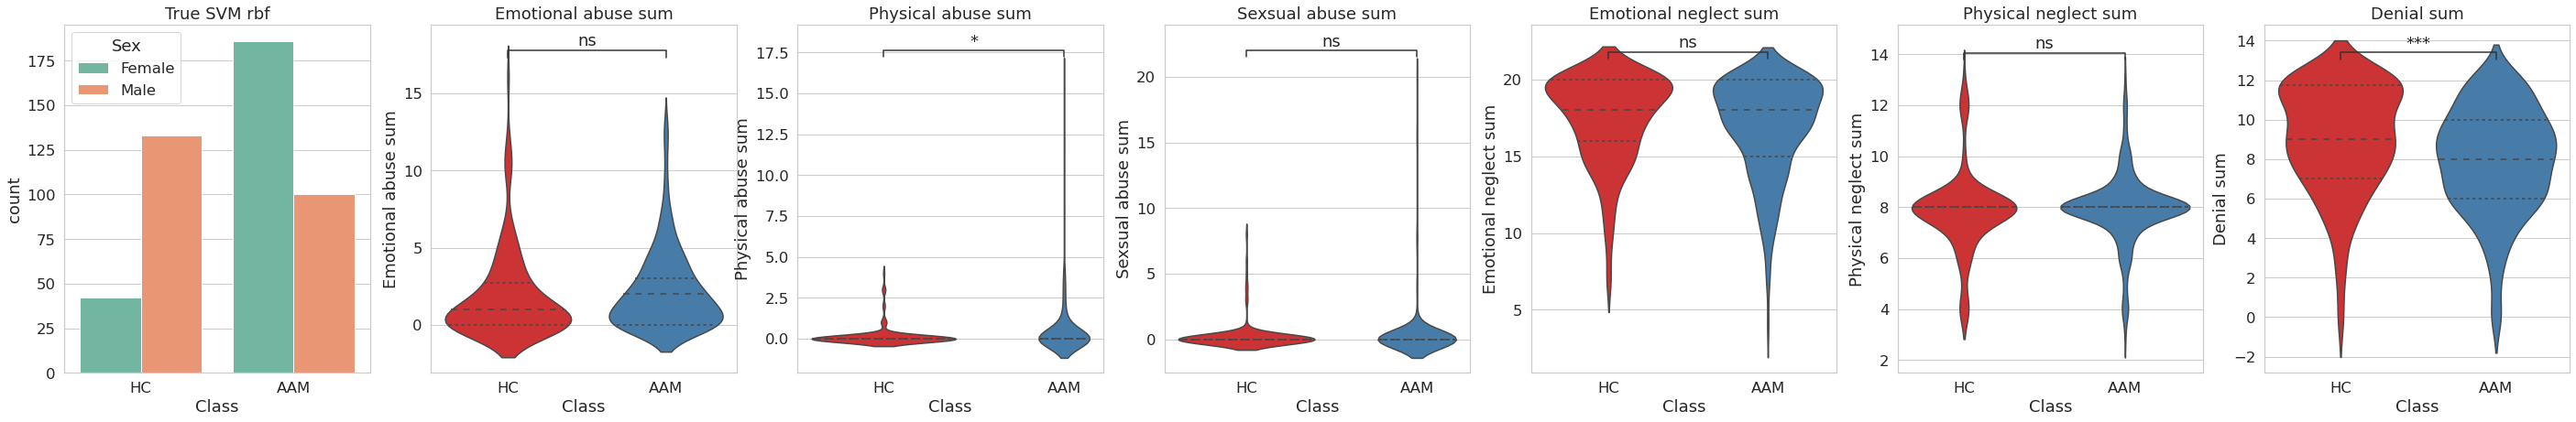

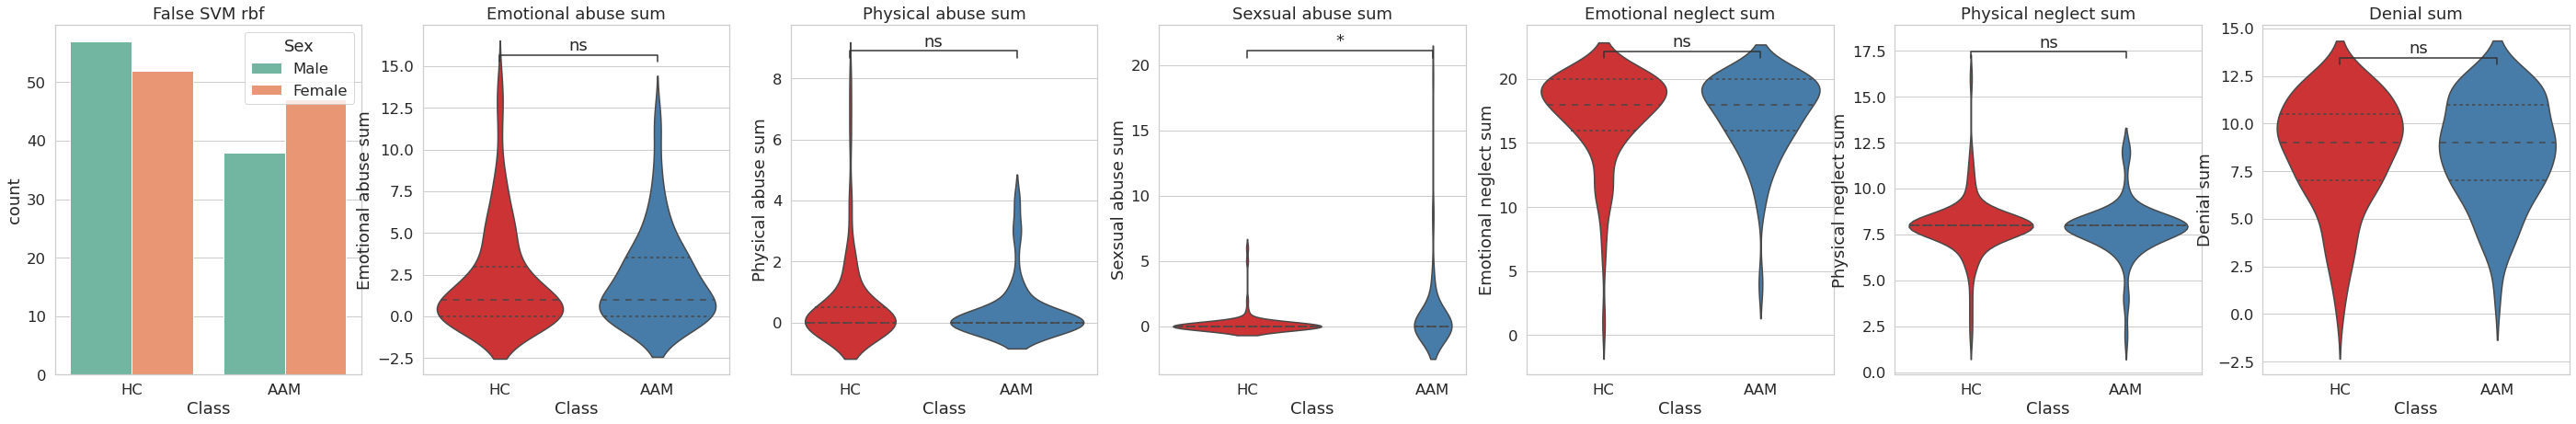

In [41]:
for (S, DF2) in [('All', binge_CTQ),
                ('True GB', binge_CTQ.set_index('ID').loc[GB_T, :]),
                ('False GB', binge_CTQ.set_index('ID').loc[GB_F, :]),
                ('True LR', binge_CTQ.set_index('ID').loc[LR_T, :]),
                ('False LR', binge_CTQ.set_index('ID').loc[LR_F, :]),
                ('True SVM lin', binge_CTQ.set_index('ID').loc[SVM_lin_T, :]),
                ('False SVM lin', binge_CTQ.set_index('ID').loc[SVM_lin_F, :]),
                ('True SVM rbf', binge_CTQ.set_index('ID').loc[SVM_rbf_T, :]),
                ('False SVM rbf', binge_CTQ.set_index('ID').loc[SVM_rbf_F, :])]:
    columns = DF2.columns[:6]
    sns.set(style="whitegrid", font_scale=1.5)
    fig, axes = plt.subplots(nrows=1, ncols=len(columns)+1,
                             figsize=((len(columns)+1)**2, len(columns)+1))
    sns.countplot(x="Class", hue='Sex', order=['HC', 'AAM'], data = DF2,
                  ax = axes[0], palette="Set2").set(title=S)
    
    for i, j in enumerate(columns):
        axes[i+1].set_title(columns[i])
        sns.violinplot(x="Class", y=j, data=DF2, order=['HC', 'AAM'],
                       inner="quartile", ax = axes[i+1], palette="Set1")
        add_stat_annotation(ax = axes[i+1], data=DF2, x="Class", y=j,
                            box_pairs = [("HC","AAM")], order=["HC","AAM"],
                            test='t-test_ind', text_format='star', loc='inside') 

### SURPS

In [42]:
SURPS = IMAGEN_instrument()
binge_SURPS = SURPS.read_instrument(
    'newlbls-fu3-espad-fu3-19a-binge-n650_SURPS.csv'
)
col_binge_SURPS = binge_SURPS.columns[:-6]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=7.854e-01 stat=2.724e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=2.579e-01 stat=1.132e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=2.612e-07 stat=-5.164e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with B

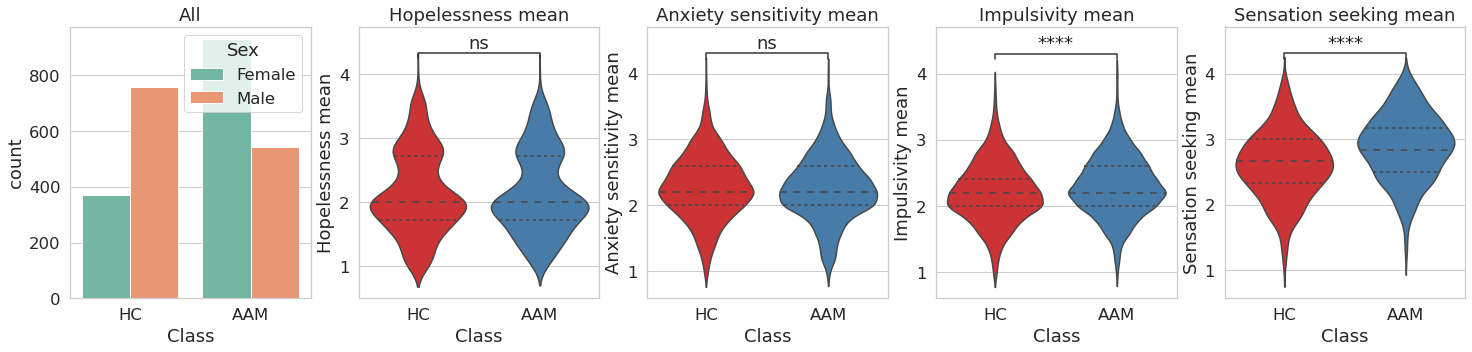

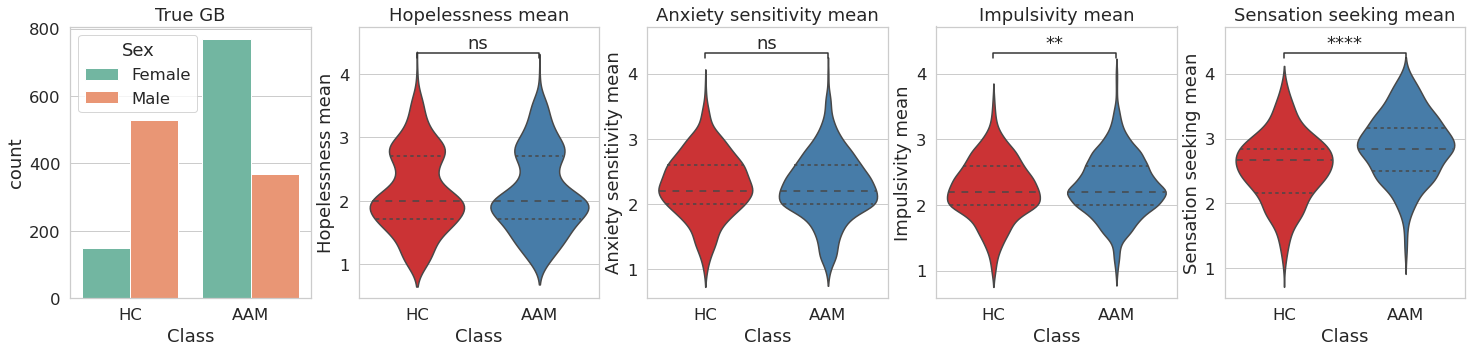

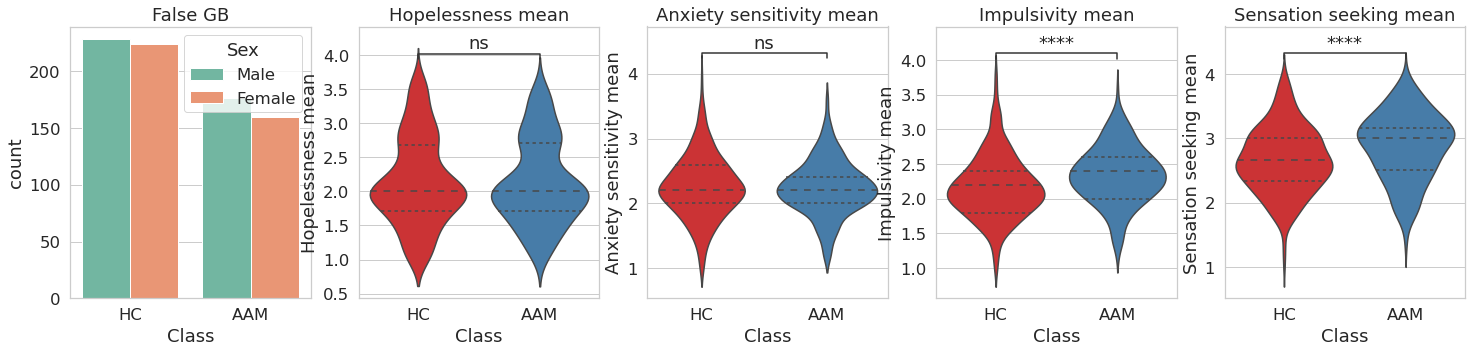

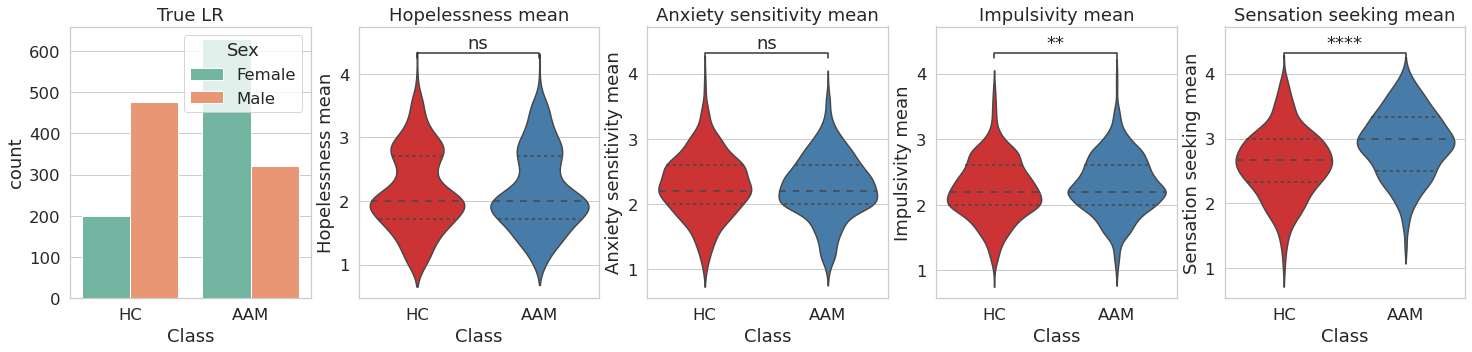

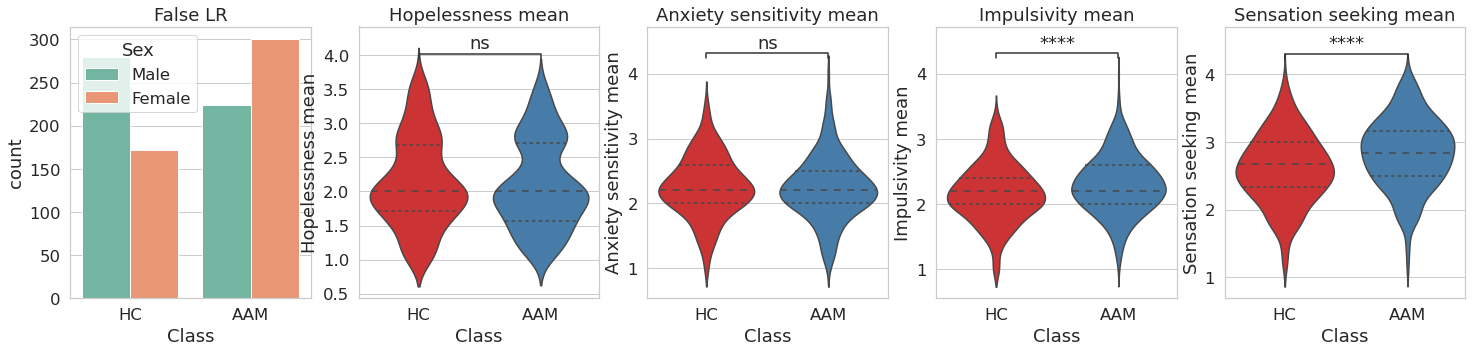

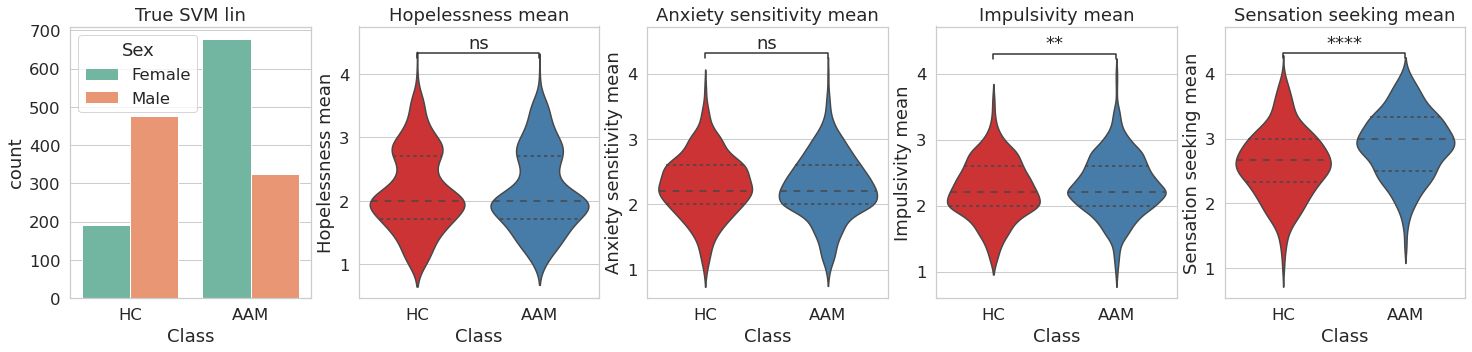

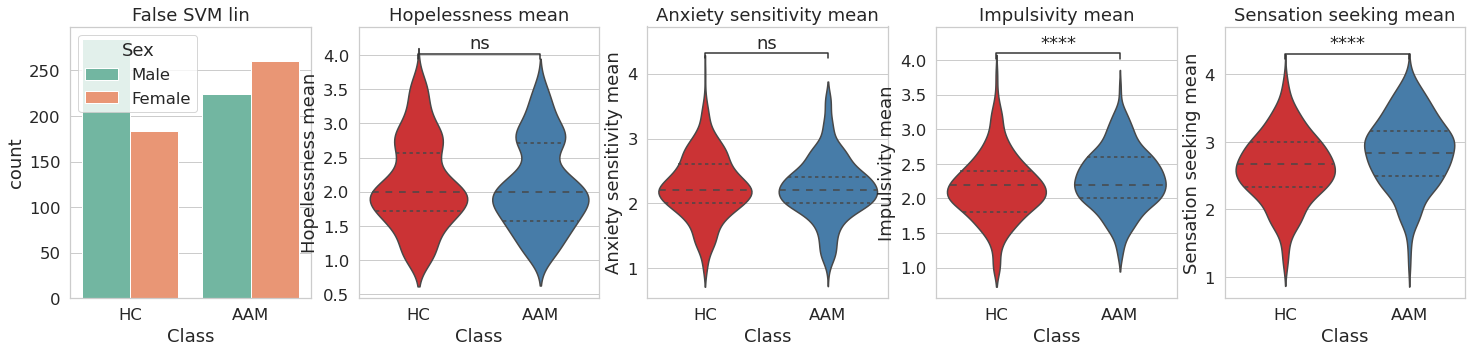

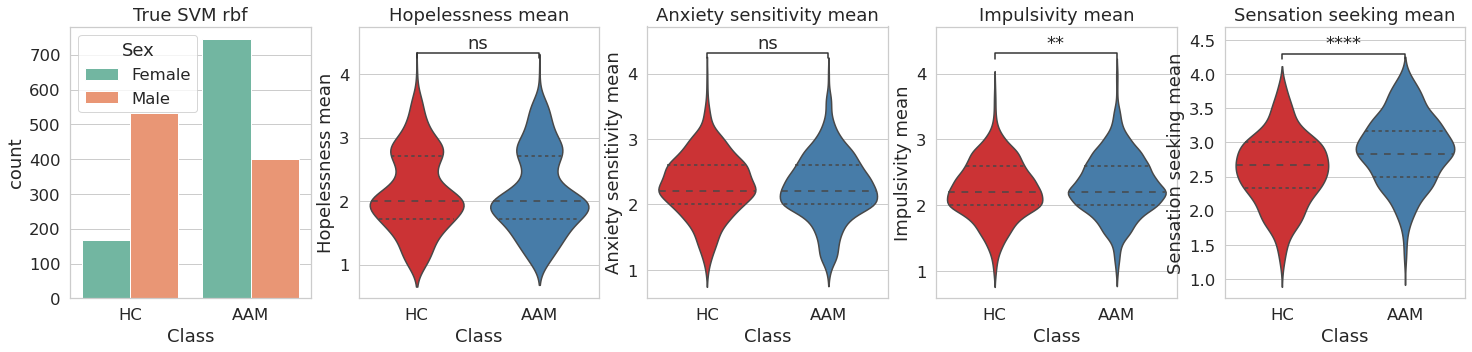

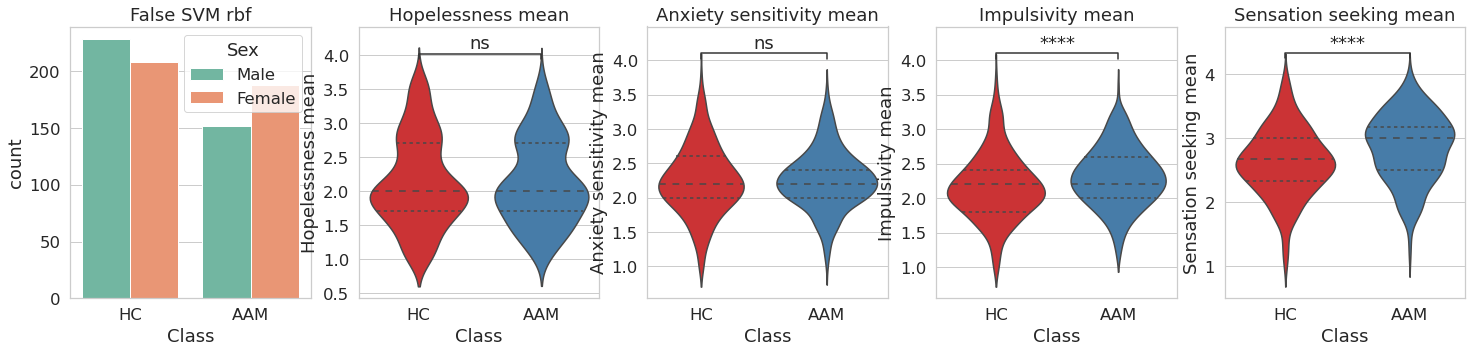

In [45]:
for (S, DF2) in [('All', binge_SURPS),
                ('True GB', binge_SURPS.set_index('ID').loc[GB_T, :]),
                ('False GB', binge_SURPS.set_index('ID').loc[GB_F, :]),
                ('True LR', binge_SURPS.set_index('ID').loc[LR_T, :]),
                ('False LR', binge_SURPS.set_index('ID').loc[LR_F, :]),
                ('True SVM lin', binge_SURPS.set_index('ID').loc[SVM_lin_T, :]),
                ('False SVM lin', binge_SURPS.set_index('ID').loc[SVM_lin_F, :]),
                ('True SVM rbf', binge_SURPS.set_index('ID').loc[SVM_rbf_T, :]),
                ('False SVM rbf', binge_SURPS.set_index('ID').loc[SVM_rbf_F, :])]:
    columns = DF2.columns[:4]
    sns.set(style="whitegrid", font_scale=1.5)
    fig, axes = plt.subplots(nrows=1, ncols=len(columns)+1,
                             figsize=((len(columns)+1)**2, len(columns)+1))
    sns.countplot(x="Class", hue='Sex', order=['HC', 'AAM'], data = DF2,
                  ax = axes[0], palette="Set2").set(title=S)
    
    for i, j in enumerate(columns):
        axes[i+1].set_title(columns[i])
        sns.violinplot(x="Class", y=j, data=DF2, order=['HC', 'AAM'],
                       inner="quartile", ax = axes[i+1], palette="Set1")
        add_stat_annotation(ax = axes[i+1], data=DF2, x="Class", y=j,
                            box_pairs = [("HC","AAM")], order=["HC","AAM"],
                            test='t-test_ind', text_format='star', loc='inside') 